# Post-processing a GRILLIX simulation

This notebook demonstrates how to perform the post-processing analysis for
a GRILLIX simulation, contained in the `sample_data` folder.

To limit the repository size, only 5 snapshot write-outs are provided. The sample data is provided primarily to demonstrate the
method by which you can generate a standard NetCDF file for another simulation,
to perform an equivalent validation.

Analysis routines are provided in the `tcvx21/grillix_analysis` folder.

In [1]:
import tcvx21
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
from tcvx21.units_m import Quantity, Dimensionless, convert_xarray_to_quantity
from tcvx21.file_io.json_io_m import read_from_json

import tcvx21.grillix_post as grillix

plt.style.use(tcvx21.style_sheet)

plt.rcParams.update({'mathtext.default': 'regular'})
plt.rcParams['figure.facecolor'] = 'white'
xr.set_options(keep_attrs=True)

In [2]:
file_path = tcvx21.sample_data
time_slice = slice(None)

file_path = Path(file_path)
assert file_path.exists()

## Setting up an interface to the data

We start by reading in the basic simulation data. For GRILLIX, this is

1. Grid: the $R,Z$ grid used for the simulation (assumed to be axisymmetric).
   Since we trim our grid at a limiting flux-surface, the data is stored as unstructured
   $(R, Z, value)$ column data. The grid allows us to map this to a matrix form $value(R, Z)$, which is needed
   for plotting and analysis.
2. Normalisation: a set of `pint.Quantity` values which allows us to go from
   normalised values to SI values. The `pint.Quantity` class is highly capable,
   allowing unit tracking through basic operations, and unit conversion.
3. `xr.Dataset` snaps: an interface to the GRILLIX snapshot data. The xarray
   module interfaces with dask to provide a memory-light interface to very
   large files. It is similar to a `pandas.DataFrame`.
4. Equi: an interface to the equilibrium file, providing data about the magnetic
   field and penalisation (which is how GRILLIX sets boundary conditions). The
   `flip_z` parameter is used to invert the toroidal field direction.

To limit the size of the tcvx21 repository, we provide only sample data over a few snapshots
of a low-resolution (2mm) case.

In [3]:
grid = grillix.components.Grid(file_path / 'vgrid.nc')
norm = grillix.components.Normalisation.initialise_from_normalisation_file(file_path/'physical_parameters.nml')
snaps = grillix.components.read_snaps_from_file(file_path, norm, time_slice=slice(None), all_planes=True)
equi = grillix.components.Equi(file_path/'TCV_ortho.nc',
                file_path/'pen_metainfo.nc',
                flip_z=True)

parameter_filepath = grillix.filepath_resolver(file_path, 'params.in')
params = grillix.components.convert_params_filepaths(parameter_filepath, grillix.components.read_fortran_namelist(parameter_filepath))

## Data extraction via "lineouts"

Now that we have the interface prepared, we want to extract values at the
set of experimental observable positions. We do this via "lineouts", which
provide an efficient way to get points at specific $R,Z$ positions.

We also need to be able to map from a flux-surface label to the
$R^u - R^u_{sep}$ coordinate. We do this via the OutboardMidplaneMap.

In [4]:
n_points = 500
omp_map = grillix.lineouts.OutboardMidplaneMap(grid, equi, norm)
omp = grillix.lineouts.outboard_midplane_chord(grid, equi, n_points=500)
lfs = grillix.lineouts.penalisation_contour(grid, equi, level=0.0, contour_index=0, n_points=n_points)
hfs = grillix.lineouts.penalisation_contour(grid, equi, level=0.0, contour_index=1, n_points=n_points)
ts = grillix.lineouts.thomson_scattering(grid, equi, tcvx21.thomson_coords_json, n_points=n_points)
rdpa = grillix.lineouts.rdpa(grid, equi, omp_map, norm, tcvx21.rdpa_coords_json)
xpt = grillix.lineouts.xpoint(grid, equi, norm)

lineouts = {
    'omp': omp,
    'lfs': lfs,
    'hfs': hfs,
    'ts': ts,
    'rdpa': rdpa,
    'xpt': xpt
}

Masking 30 of 403 RDPA points


We also want to be able to calculate parallel gradients. In GRILLIX, this
is done via the FCI method. A simplified trace-and-interpolate method
is demonstrated here. Note that since we're interpolating in Python,
this is very slow!

To speed things up a little, we trace only once per lineout, and only
for the lineouts where we need parallel gradients.

(Unfortunately, dask-based parallelism raises a strange `CancelledError` when
these loops are attempted to be parallelized)

In [5]:
%%time
grillix.observables.initialise_lineout_for_parallel_gradient(lfs, grid, equi, norm, params['params_grid']['npol'], stored_trace=file_path/f'lfs_trace_{n_points}.nc')
# We don't compute the heat flux for the HFS, so can save time by not tracing for it

Attempting to read stored trace from /Users/tbody/Documents/work/tcv-x21/tests/sample_data/lfs_trace_500.nc
CPU times: user 2.1 s, sys: 32.2 ms, total: 2.14 s
Wall time: 2.17 s


As a sanity check, it's always a good idea to plot things before we perform the
analysis.

The lfs and hfs lineouts in GRILLIX are defined at positions which don't exactly
correspond to the physical wall. This is because GRILLIX uses a smooth
penalisation characteristic function. The lfs and hfs positions are defined as
the surface where we *start* to apply boundary conditions. For more details
on this method, see Stegmeir et al., 2019.

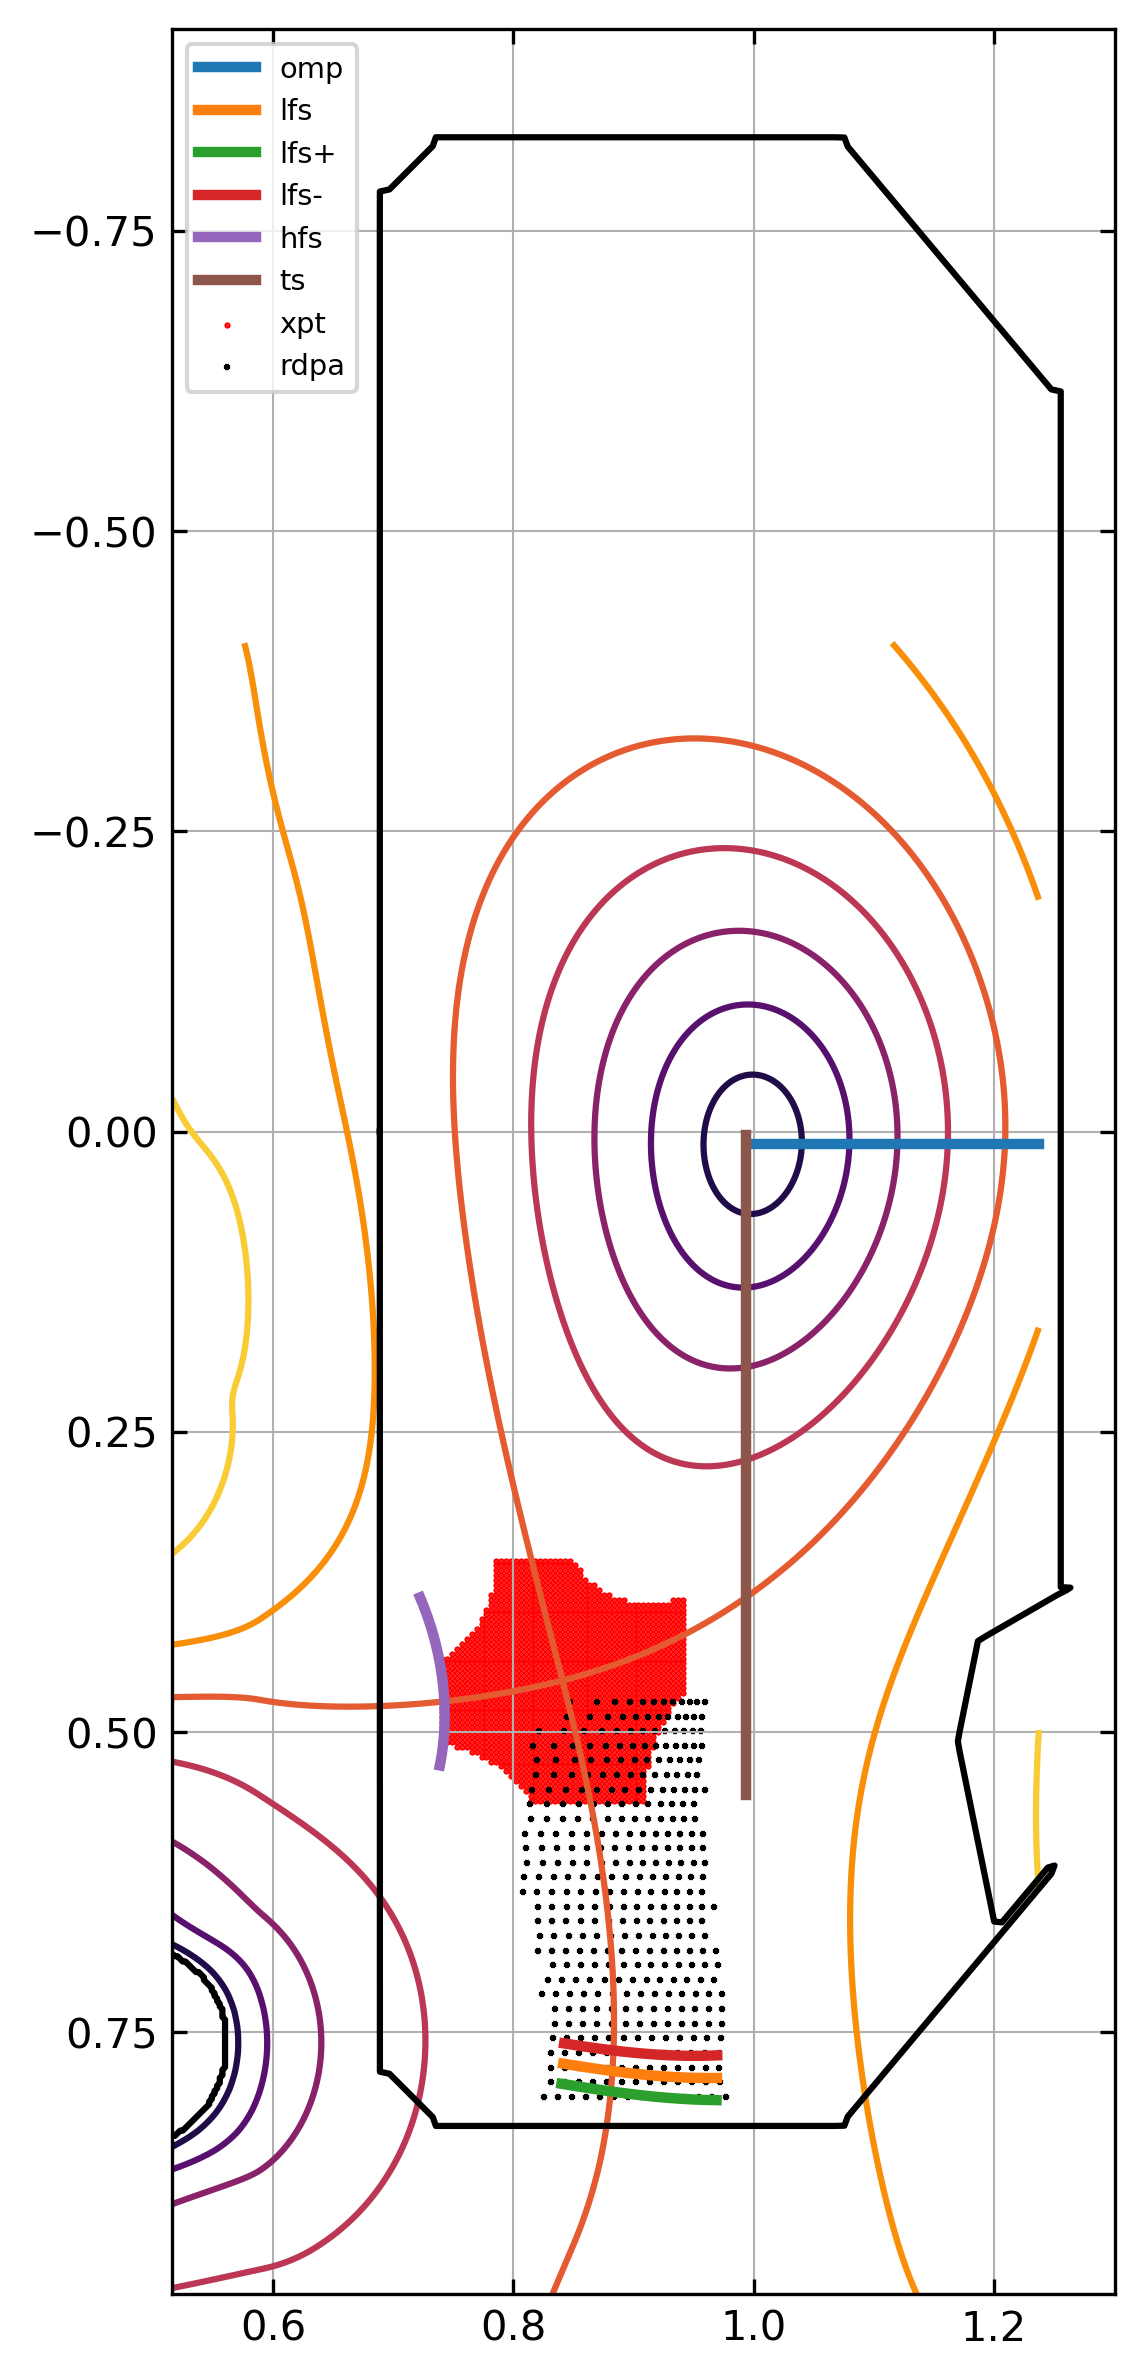

In [6]:
divertor_ = read_from_json(tcvx21.divertor_coords_json)

_, ax = plt.subplots(figsize=(10,10))
plt.contour(grid.r_s, grid.z_s, equi.normalised_flux_surface_label(grid.r_s, grid.z_s))

plt.scatter(lineouts['xpt'].r_points, lineouts['xpt'].z_points, s=1, marker='.', color='r', label='xpt')
plt.scatter(lineouts['rdpa'].r_points, lineouts['rdpa'].z_points, s=1, marker='+', color='k', label='rdpa')

for key, lineout in lineouts.items():

    if key in ['rdpa', 'xpt']:
        continue

    plt.plot(lineout.r_points, lineout.z_points, label=key, linewidth=2.5)

    if hasattr(lineout, 'forward_lineout'):
        plt.plot(lineout.forward_lineout.r_points, lineout.forward_lineout.z_points, label=f"{key}+", linewidth=2.5)
    if hasattr(lineout, 'reverse_lineout'):
        plt.plot(lineout.reverse_lineout.r_points, lineout.reverse_lineout.z_points, label=f"{key}-", linewidth=2.5)

plt.legend()
if equi.flipped_z:
    ax.invert_yaxis()
ax.set_aspect('equal')

plt.plot(divertor_['r_points']/equi.axis_r.values,
         divertor_['z_points']/equi.axis_r.values * -1.0 if equi.flipped_z else 1.0,
         color='k')

## Interfacing with the snaps

The `snaps` object (an `xarray` labelled multi-dimensional array) provides
convenient access to the simulation data. We mostly focus on 1D lineouts
which can be compared to the experimental diagnostics, but we demonstrate
here the use of the analysis components to show the density perturbation.

Text(0.5, 1.0, 'Density perturbation')

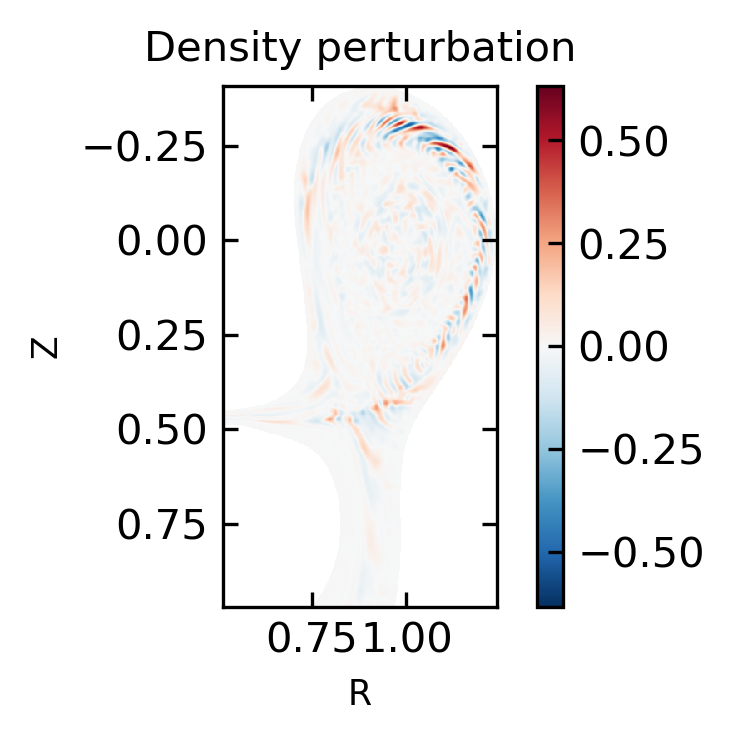

In [7]:
fig, ax = plt.subplots()
grid.shape(snaps.density.isel(tau=0, phi=0) - snaps.density.mean(dim=('tau', 'phi'))).plot(shading='flat')

ax.invert_yaxis()
ax.set_aspect('equal')
ax.set_title('Density perturbation')

## Demonstrating the lineout functionality

Looks good! Next, let's test the lineout functionality. If you just want
normalised units, it's very easy using the xarray functionality.

This one-liner has a lot going on, so let's unpack it
1. `lineouts[omp]` requests the stored omp `Lineout`
2. `.interpolate(` calls the interpolate method
3. `snaps.density` requests the density stored in the snaps
4. `).mean(dim='phi')` toroidally averages the result (since snaps.density has
   `phi, tau, points` dimensions, the lineout will have `phi, tau, interp_points`
   dimensions. We want to plot 2D, so average over `phi` to eliminate this dimension).
5. `.plot()` is a thin wrapper of `matplotlib.pyplot.pcolormesh`, which automatically
   sets the x and y values of the plot from the xarray coordinates

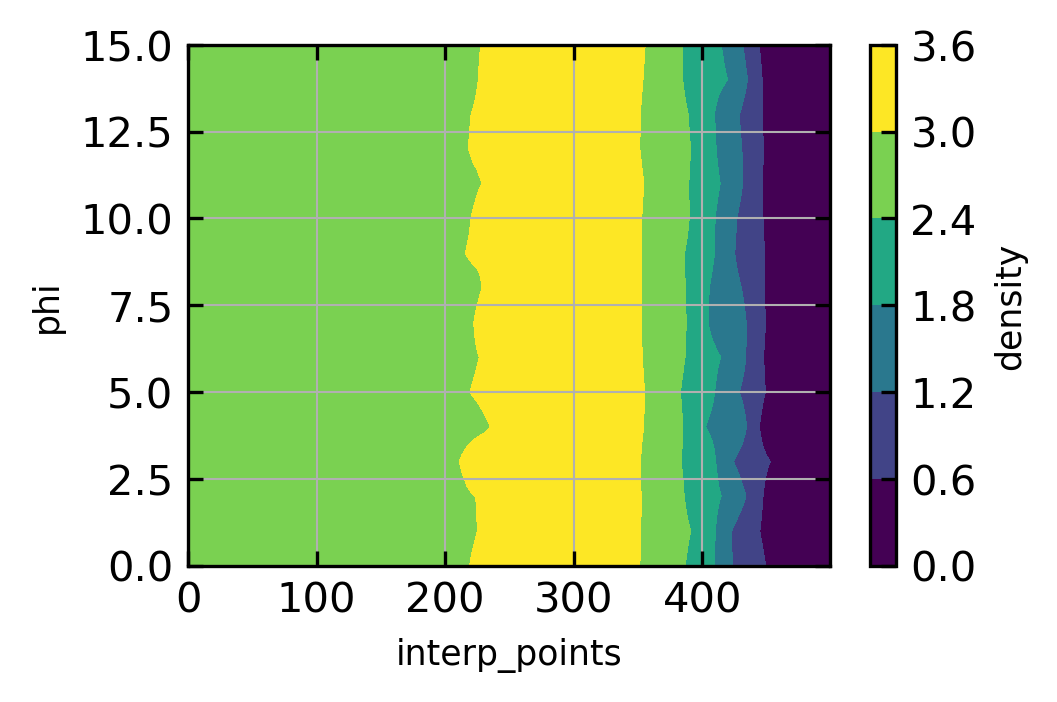

In [8]:
lineouts['omp'].interpolate(snaps.density).mean(dim='tau').plot.contourf()

What about if we want this in SI units? Unfortunately, xarray isn't completely
compatible with `pint`, so we have to manually convert to `pint.Quantity` objects
and then set up the plotting manually.

N.b. the underscore in the variable names is simply to indicate that these variables
are private -- i.e. they shouldn't be used in other routines (since Python
automatically promotes variables outside of functions to global scope. This
is something to be careful about in Jupyter notebooks).

You can see that the result doesn't vary much with time,
but that's not surprising since 5 snaps is only 8 microseconds
of plasma time!

/var/folders/_s/10lb2_b164b_w7dsfq07njbr0000gn/T/ipykernel_28908/3515298647.py:10: UserWarning: The following kwargs were not used by contour: 'shading'
  plt.contourf(lineout_ru_, tau_, lineout_density_, shading='nearest')


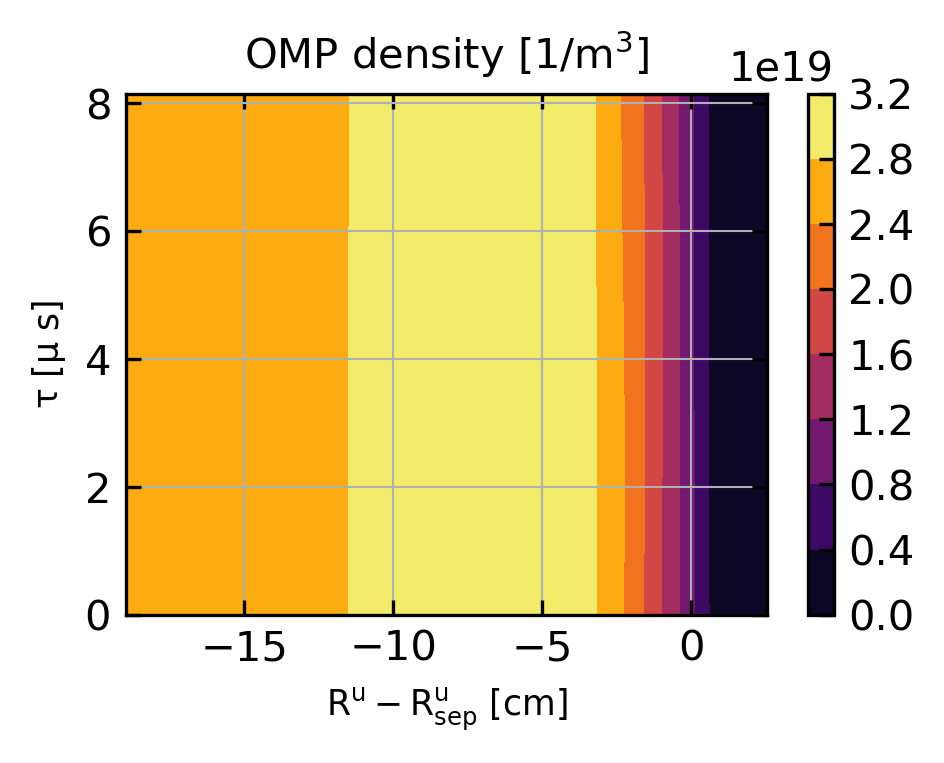

In [9]:
tau_ = convert_xarray_to_quantity(snaps.tau).to('microseconds')
tau_ -= tau_[0]

lineout_ = lineouts['omp']
lineout_rho_ = equi.normalised_flux_surface_label(lineout_.r_points, lineout_.z_points, grid=False)
lineout_ru_ = convert_xarray_to_quantity(omp_map.convert_rho_to_distance(lineout_rho_)).to('cm')

lineout_density_ = convert_xarray_to_quantity(lineout_.interpolate(snaps.density).mean(dim='phi')).to('1/m^3')

plt.contourf(lineout_ru_, tau_, lineout_density_, shading='nearest')
plt.colorbar()

plt.ylabel('$\\tau$ [$\\mu$ s]')
plt.xlabel('$R^u - R^u_{sep}$ [cm]')
plt.title('OMP density [$1/m^3$]');

## Synthetic diagnostics and bootstrap

For observables which do not directly map to the simulation dynamic quantities,
we need a method to estimate what the measured value will be given plasma
parameters from the simulation. These can be roughly termed *synthetic
diagnostics*, although we use here only simple approximations. The functions
are stored in the `experimental_quantities_m.py` file.

We show here how to calculate the skewness of the ion saturation current measured the low-field-side
target Langmuir probe array.

This method also gives an estimate of the uncertainty of the statistical moment via the
bootstrap method. The bootstrap method takes several random samples of the signal (potentially
double-counting some points and omitting others) and then calculates the mean
and standard deviation of the statistical moments calculated from the random samples.
Strictly speaking it should be applied for purely random data, rather than correlated
data, but we use it nevertheless because it is a nice and simple approximation of the
finite-sampling error.

For the mean, the bootstrap error is tiny, but for the higher-order statistical moments it
can be appreciable.

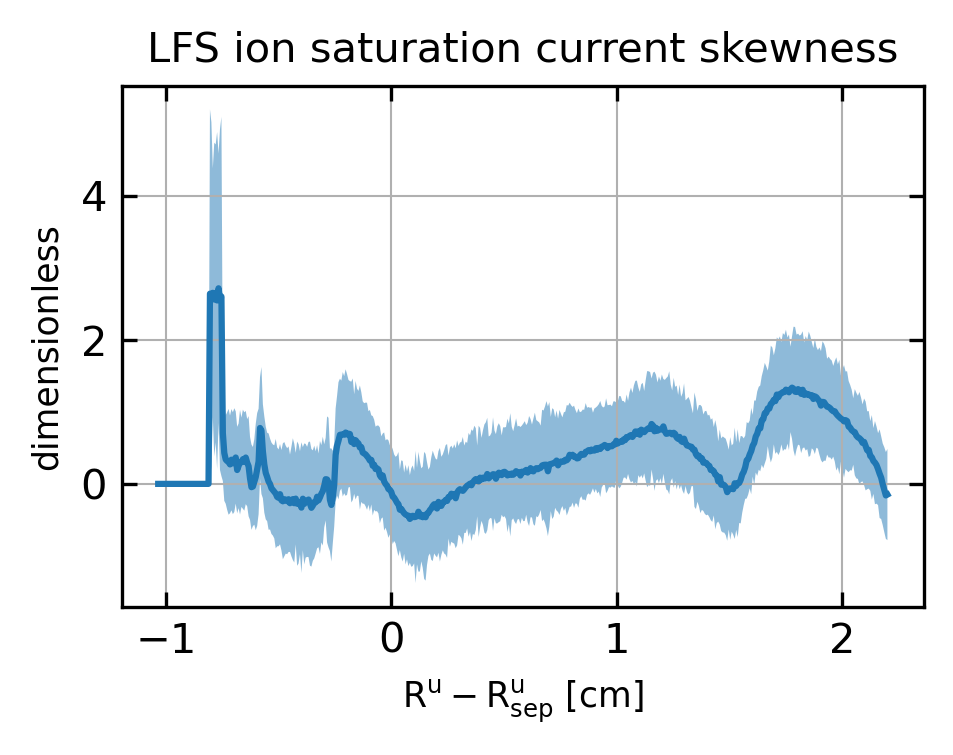

In [10]:
lineout_ = lineouts['lfs']
lineout_rho_ = equi.normalised_flux_surface_label(lineout_.r_points, lineout_.z_points, grid=False)
lineout_ru_ = convert_xarray_to_quantity(omp_map.convert_rho_to_distance(lineout_rho_)).to('cm')

sound_speed_ = grillix.observables.sound_speed(electron_temp=snaps.electron_temp,
                                        ion_temp=snaps.ion_temp,
                                        norm=norm)

jsat_ = grillix.observables.ion_saturation_current(density=snaps.density,
                                            sound_speed=sound_speed_,
                                            norm=norm,
                                            wall_probe=True)

jsat_skew_, jsat_skew_err_ = tcvx21.analysis.compute_statistical_moment_with_bootstrap(lineout_.interpolate(jsat_).rename({'interp_points': 'points'}), moment='skew')

jsat_skew_ = convert_xarray_to_quantity(jsat_skew_)
jsat_skew_err_ = convert_xarray_to_quantity(jsat_skew_err_)

plt.plot(lineout_ru_, jsat_skew_)
plt.fill_between(lineout_ru_, jsat_skew_+jsat_skew_err_, jsat_skew_-jsat_skew_err_, alpha=0.5)

plt.xlabel('$R^u - R^u_{sep}$ [cm]')
plt.title('LFS ion saturation current skewness');

## Heat flux profile fitting

A more involved synthetic diagnostic is the parallel heat flux to the
boundaries. From our anomalous heat transmission boundary conditions, we can
determine the heat flux to the boundaries as

$q_{\parallel,e} = \frac{5}{2}n v_{\parallel,e}T_e + \frac{5}{2}n u_{E\times B}T_e - \chi_{\parallel e,0} T_e^{5/2}\nabla_\parallel T_e$

$q_{\parallel,i} = \frac{5}{2}n u_{\parallel,i}T_i + \frac{5}{2}n u_{E\times B}T_i - \chi_{\parallel i,0} T_i^{5/2}\nabla_\parallel T_i$

We can check the heat flux routines and the contribution from each component here.
Note that, unless the $E \times B$ contribution is included, the heat flux
can become negative.

You notice that there's a lot of terms in this equation.
$q_\parallel$ isn't directly evolved in the code, so it has
a lower simulation hierarchy than other simpler observables.

lambda_q = 0.311 millimeter±0.278 millimeter


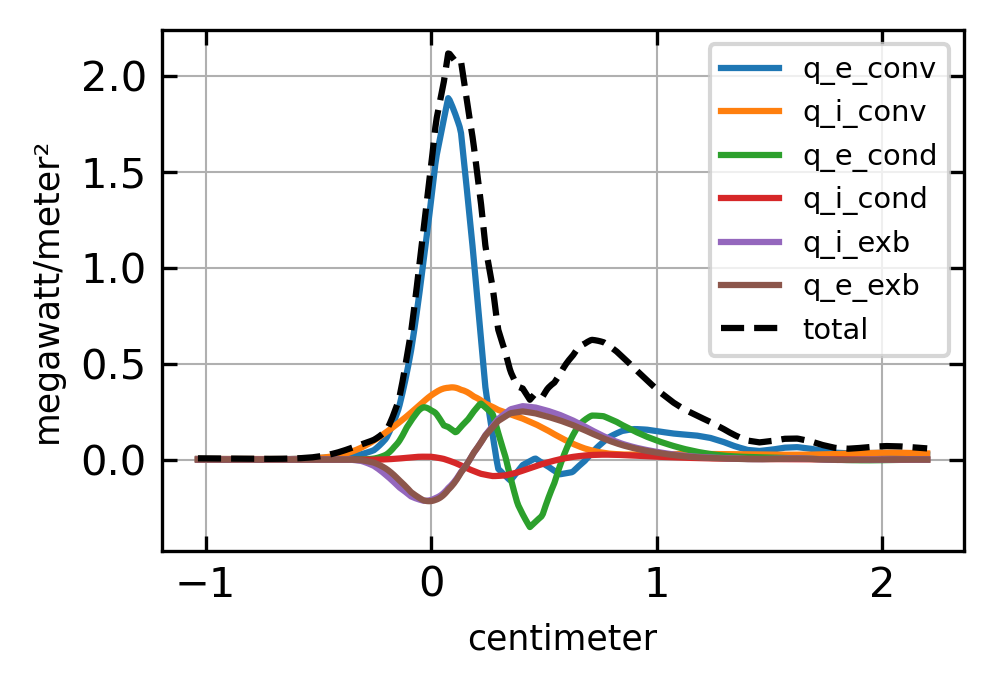

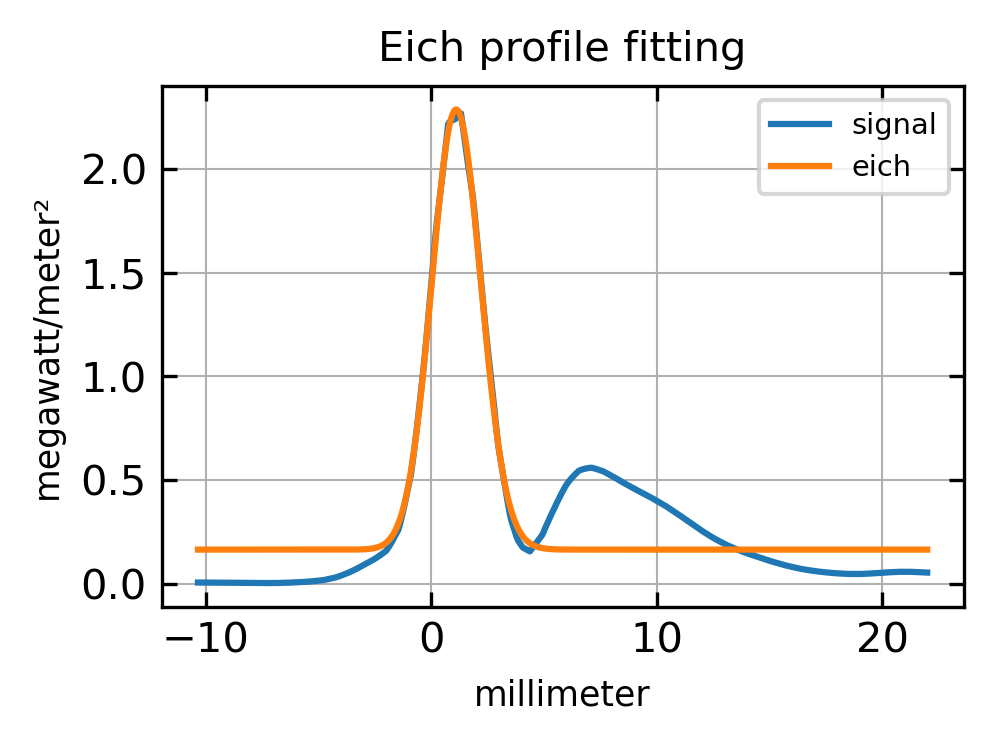

In [11]:
lineout_ = lineouts['lfs']
lineout_rho_ = equi.normalised_flux_surface_label(lineout_.r_points, lineout_.z_points, grid=False)
lineout_ru_ = convert_xarray_to_quantity(omp_map.convert_rho_to_distance(lineout_rho_)).to('cm')

density = lineout_.interpolate(snaps.density)
ion_velocity = lineout_.interpolate(snaps.velocity)
current = lineout_.interpolate(snaps.current)
electron_temp = lineout_.interpolate(snaps.electron_temp)
electron_temp_parallel_gradient = grillix.observables.compute_gradient_on_plane(lineout_, snaps.electron_temp, plane=0)
ion_temp = lineout_.interpolate(snaps.ion_temp)
ion_temp_parallel_gradient = grillix.observables.compute_gradient_on_plane(lineout_, snaps.ion_temp, plane=0)
effective_parallel_exb = lineout_.interpolate(grillix.observables.effective_parallel_exb_velocity(grid, equi, norm, snaps.potential))

q_e_conv = grillix.observables.heat_flux.electron_parallel_heat_convection(density, electron_temp, ion_velocity, current, norm).isel(tau=0, phi=0)
q_i_conv = grillix.observables.heat_flux.ion_parallel_heat_convection(density, ion_temp, ion_velocity, norm).isel(tau=0, phi=0)
q_e_cond = grillix.observables.heat_flux.electron_parallel_heat_conduction(electron_temp, electron_temp_parallel_gradient, norm).isel(tau=0, phi=0)
q_i_cond = grillix.observables.heat_flux.ion_parallel_heat_conduction(ion_temp, ion_temp_parallel_gradient, norm).isel(tau=0, phi=0)
q_e_exb = grillix.observables.heat_flux.exb_effective_parallel_heat_convection(density, electron_temp, effective_parallel_exb, norm).isel(tau=0, phi=0)
q_i_exb = grillix.observables.heat_flux.exb_effective_parallel_heat_convection(density, ion_temp, effective_parallel_exb, norm).isel(tau=0, phi=0)

q_par = grillix.observables.total_parallel_heat_flux(density, electron_temp, electron_temp_parallel_gradient,
                             ion_temp, ion_temp_parallel_gradient,
                             ion_velocity, current, effective_parallel_exb, norm).load()

plt.plot(lineout_ru_, convert_xarray_to_quantity(q_e_conv), label='q_e_conv')
plt.plot(lineout_ru_, convert_xarray_to_quantity(q_i_conv), label='q_i_conv')
plt.plot(lineout_ru_, convert_xarray_to_quantity(q_e_cond), label='q_e_cond')
plt.plot(lineout_ru_, convert_xarray_to_quantity(q_i_cond), label='q_i_cond')
plt.plot(lineout_ru_, convert_xarray_to_quantity(q_i_exb), label='q_i_exb')
plt.plot(lineout_ru_, convert_xarray_to_quantity(q_e_exb), label='q_e_exb')

plt.plot(lineout_ru_, convert_xarray_to_quantity(q_par.isel(tau=0, phi=0)), 'k--', label='total')

plt.legend()

plt.figure()
_, lambda_q, _, _, _ = tcvx21.analysis.fit_eich_profile(lineout_ru_,
                                                  convert_xarray_to_quantity(q_par.mean(dim=('tau','phi'))),
                                                  plot=True)

print(f"lambda_q = {lambda_q[0]:4.3}±{lambda_q[1]:4.3}")

## 2D data from the divertor volume

As well as 1D profiles, we also have 2D profiles from the reciprocating
divertor probe array. Since the plasma can move relative to the wall,
we use $R^u - R^u_{omp}$ and $Z$ instead of the original $R, Z$ coordinates.
This means that our sample grid is not rectangular. We need to sample our
data on the unstructured grid.

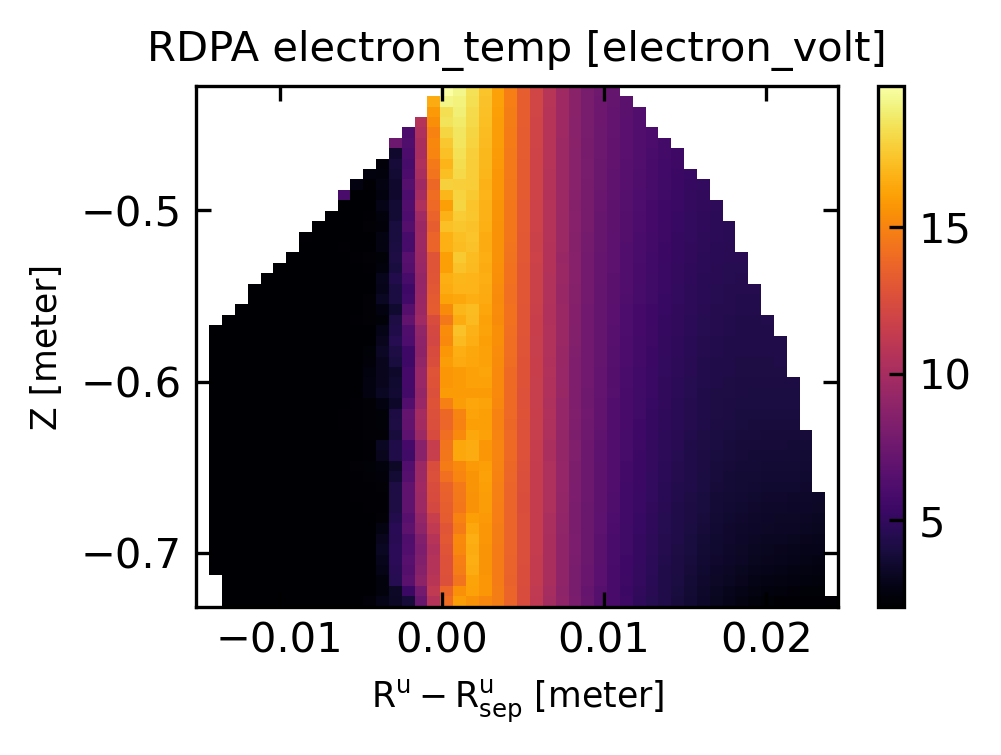

In [12]:
from scipy.interpolate import griddata

def plot_rdpa_field(rdpa_lineout, field, n_rsep=50, n_z=50):

    x = rdpa_lineout.coords['Rsep']
    y = rdpa_lineout.coords['Z']
    assert x.shape == y.shape
    z = rdpa_lineout.interpolate(field)

    x_sample = np.linspace(x.min(), x.max(), num=n_rsep)
    y_sample = np.linspace(y.min(), y.max(), num=n_z)
    x_mesh, y_mesh = np.meshgrid(x_sample, y_sample)

    z_sample = griddata(points=(x.magnitude, y.magnitude),
                        values=z,
                        xi=(x_mesh.magnitude, y_mesh.magnitude))

    z_sample *= z.norm

    plt.pcolormesh(x_sample, y_sample, z_sample, shading='nearest')
    plt.colorbar()
    plt.xlabel("$R^u - R^u_{sep}$"+f" [{x.units}]")
    plt.ylabel(f"Z [{y.units}]")
    plt.title(f"RDPA {z.name} [{z_sample.units}]")

plot_rdpa_field(lineouts['rdpa'], snaps.electron_temp.mean(dim=('phi', 'tau')))

## Integral values for sources

As well as profiles, we are also interested in integrals of the sources, to determine whether
we are using a source in the region of the experimental values.

The sources in GRILLIX are given in the file tcvx21/grillix_analysis/sources_m.py. In GRILLIX we have
set a 'constant-power, constant-particle' source. That is, we actively adapt our electron-temperature
source to compensate for the power due to the particle source. This way, we inject a constant
150kW exactly. This is deposited in the core as a temperature source. However, since the density source
also contributes to the power source we compensate for this by adding a negative temperature source
at the edge.

$P = \frac{3}{2}\int n S_{T_e} + (T_e + T_i) S_n \textrm{d}^3V$

We are using
$S_n = n_0 / \tau_0 \hat{S}_n$
where

$\hat{S}_n = \hat{S}_{n0} f_{S,n}(R,Z) = \hat{S}_{n0} \exp\left[-\left(\rho(R,Z)^2 - \rho_{cn}^2 \right)/\rho_{wn}^2\right]$

for $\rho_{cn} = 0.815$ and $\rho_{wn} =0.083$, and

$S_{Te} = T_{0} / \tau_0 \left(\frac{1}{\hat{n}}\hat{S}_{Te} - \frac{\hat{T}_e + \hat{T}_i}{\hat{n}} \hat{S}_n \right)$

where

$\hat{S}_{Te} = \hat{S}_{Te0} f_{S,Te}(R,Z) = \hat{S}_{Te0} \left(1 - \mathcal{S}_3(\rho, \rho_{cT}, \rho_{wT})\right)$

for $\mathcal{S}_3(x, c, w)$ is a third-order [smoothstep](https://en.wikipedia.org/wiki/Smoothstep) function
centred at $c$ and of transition width $w$.

This allows us to write

$P = \frac{3}{2}\iiint n_0 \hat{n} T_{0} / \tau_0 \left(\frac{1}{\hat{n}}\hat{S}_{Te} - \frac{\hat{T}_e + \hat{T}_i}{\hat{n}} \hat{S}_n \right) + T_0(\hat{T}_e + \hat{T}_i) n_0 / \tau_0 \hat{S}_n \textrm{d}^3V$

$P= \frac{3}{2}\frac{n_0 T_0}{\tau_0} \iiint \hat{S}_{Te} - (\hat{T}_e + \hat{T}_i) \hat{S}_n + (\hat{T}_e + \hat{T}_i) \hat{S}_n \textrm{d}^3V$

$P= \frac{3}{2}\frac{n_0 T_0}{\tau_0} \hat{S}_{Te0} \iiint f_{S,Te}(R,Z) \textrm{d}^3V$

$P= \frac{3}{2}\frac{n_0 T_0}{\tau_0} \hat{S}_{Te0} \mathcal{V}_w$

That is, our power injection is determined entirely by our core electron temperature source.

In [13]:
grillix.components.integrated_sources(grid, equi, norm, params, snaps);

The integrated particle source rate is 1.856e+21 / second
The integrated power source is 150.015 kilowatt
The density source required 54.943 kilowatt, which was compensated by a temperature sink


## Iterating over all observables

The final step to producing a standard NetCDF file for comparison is to iterate over each element
of the standard dictionary and fill the dictionary with results.
We then use the `RecordWriter`
to convert the standard dictionary into a NetCDF file.

Since the raw data is very large (does not fit in memory), we do a two-step post-processing. In the first step, we iterate
over the time points in our raw data to compute the raw observables at the observable positions.
These are iteratively written to an intermediate processing file. In the second
step, we perform statistics over the processing file, calculating the data used for the validation
analysis.

The first step is done with the `fill_work_file()` method of the `DataExtract` object.

In [14]:
from tcvx21.grillix_post.work_file_writer_m import WorkFileWriter

(file_path/'processing_file.nc').unlink(missing_ok=True)

data = WorkFileWriter(file_path=file_path,
                      work_file=file_path/'processing_file.nc',
                      toroidal_field_direction='forward',
                      make_work_file=True)

data.fill_work_file()

Setting up core analysis
Making lineouts
Masking 30 of 403 RDPA points
Tracing for parallel gradient
Attempting to read stored trace from /Users/tbody/Documents/work/tcv-x21/tests/sample_data/lfs_trace_500.nc
Initialising work file
Reading data from snap 0 to last snap(currently 5), length 1000
The integrated particle source rate is 1.856e+21 / second
The integrated power source is 150.015 kilowatt
The density source required 54.942 kilowatt, which was compensated by a temperature sink
Work file initialised
Done
First snap: 0, current_snap: 0, last_snap: 5
Processing snap 0 of 5 (t=0/5)
Processing snap 1 of 5 (t=1/5)
Processing snap 2 of 5 (t=2/5)
Processing snap 3 of 5 (t=3/5)
Processing snap 4 of 5 (t=4/5)
Done


In the second step, we need to make a `Record`, which is a NetCDF file formatted according
to the data template in `observables.json`.

The validation is done in terms of statistical moments, rather than raw values.

To compute statistical values and the uncertainty associated with it, we use the bootstrap
method. We take samples from all toroidal planes, and 1ms of data (500 snaps).

We select values from the samples available for each observable point *with replacement*. This means that some points may be double-counted,
and some may be missed entirely.

We repeat this a number of times, to generate a number of *tests*.

Finally, we compute the median of the tests and a confidence interval -- which gives us a
robust estimator for the statistical moment and its uncertainty.

The 65% and 95% confidence intervals are shown for the different statistical moments of $J_{sat}$

Note that since we only have 5 time points here, the uncertainty is
higher than for the real result with 500 time points.

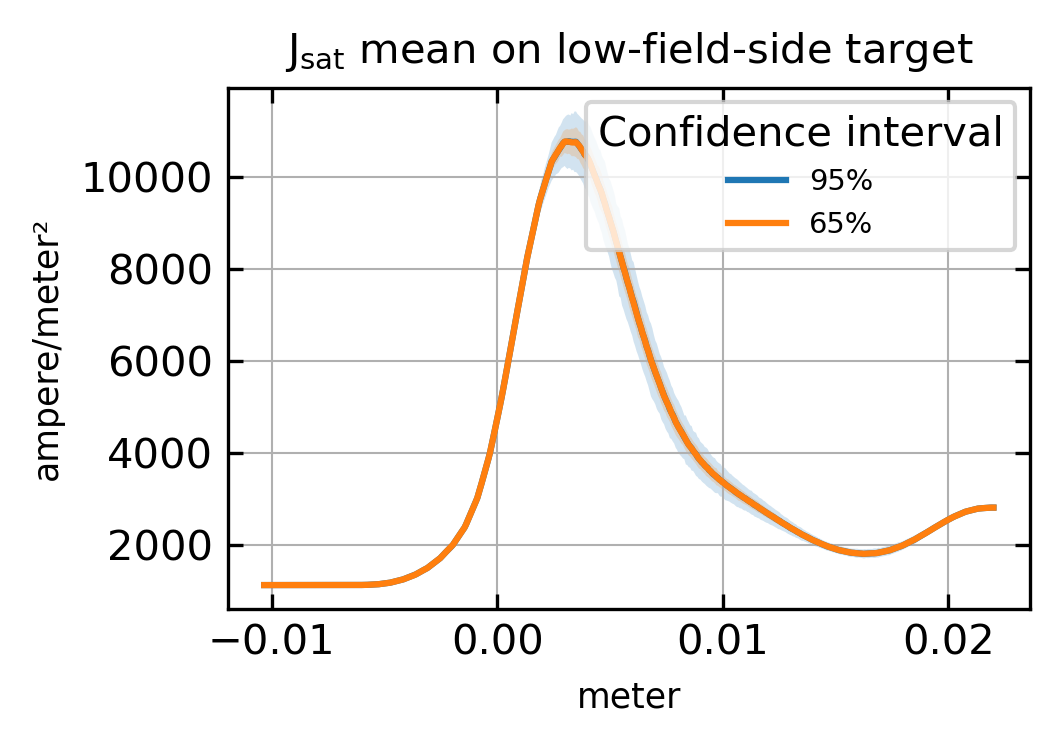

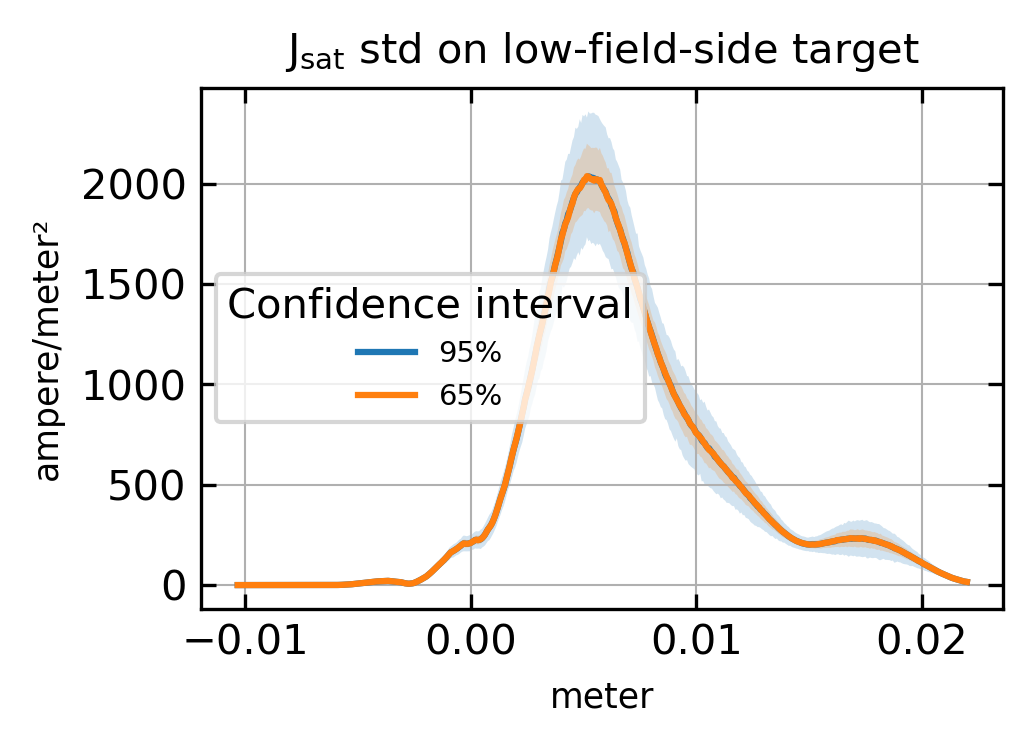

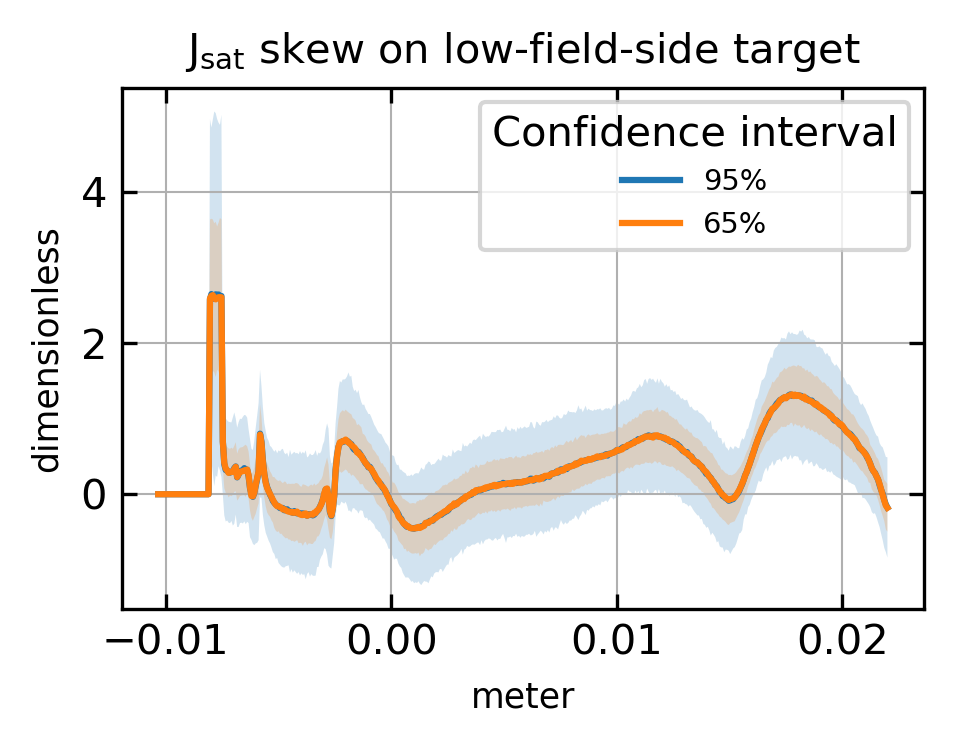

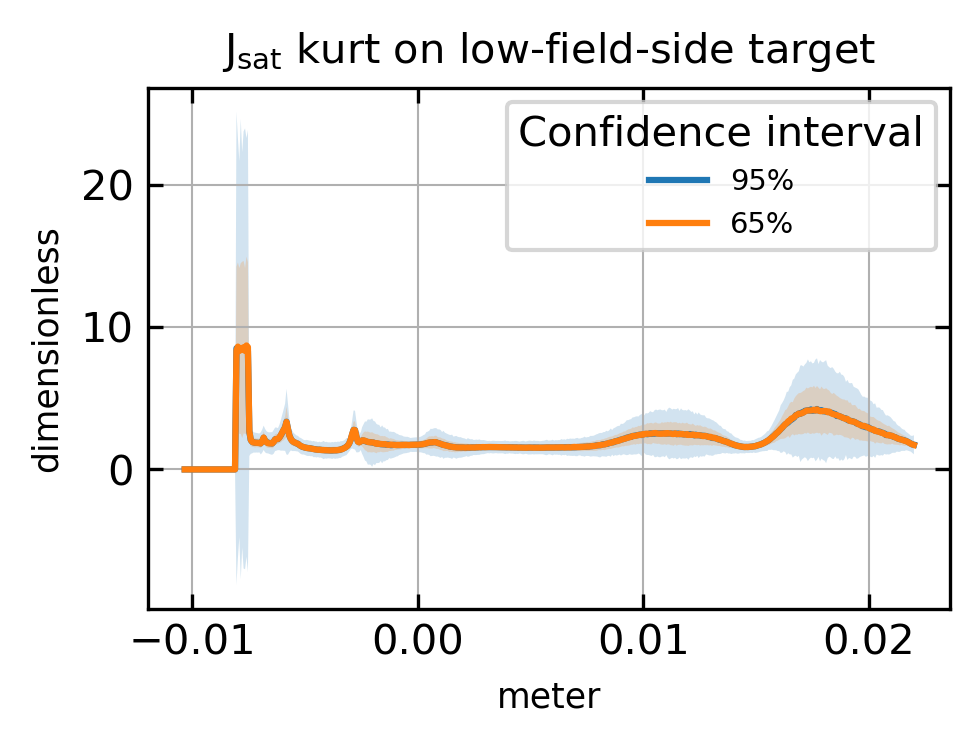

In [15]:
import xarray as xr

def Q(netcdf_array):
    """Converts netcdf arrays to Quantities"""
    return Quantity(netcdf_array.values, netcdf_array.units)

def plot_region(x, y, dy, label):
    plt.plot(x, y, label=label)
    plt.fill_between(x, y-dy, y+dy, alpha=0.2)

work_file_path = file_path/'processing_file.nc'
values = xr.open_dataset(work_file_path, group='LFS-LP/observables').jsat.isel(tau=slice(-500, None)).persist()
Rsep = Q(xr.open_dataset(work_file_path, group='LFS-LP').Rsep)

for moment in ['mean', 'std', 'skew', 'kurt']:
    plt.figure()
    
    mean, error = tcvx21.analysis.compute_statistical_moment_with_bootstrap(values=values, moment=moment, ci=0.95, n_tests=1000)
    plot_region(Rsep, Q(mean), Q(error), label='95%')

    mean, error = tcvx21.analysis.compute_statistical_moment_with_bootstrap(values=values, moment=moment, ci=0.65, n_tests=1000)
    plot_region(Rsep, Q(mean), Q(error), label='65%')

    plt.legend(title='Confidence interval')
    plt.title(f'$J_{{sat}}$ {moment} on low-field-side target');

In [16]:
from netCDF4 import Dataset

standard_dict = read_from_json(tcvx21.template_file)
simulation_hierarchy = read_from_json(file_path/'simulation_hierarchy.json')
work_file_path = file_path/'processing_file.nc'

dataset = Dataset(work_file_path)

def strip_moment(observable_key):
    if observable.endswith('_std'):
        moment = 'std'
        key = observable_key.rstrip('std').rstrip('_')
    elif observable.endswith('_skew'):
        moment = 'skew'
        key = observable_key.rstrip('skew').rstrip('_')
    elif observable.endswith('_kurtosis'):
        moment = 'kurt'
        key = observable_key.rstrip('kurtosis').rstrip('_')
    else:
        moment = 'mean'
        key = observable_key
    return key, moment

def write_observable(diagnostic_key, observable_key, output_dict):

    print(f"\tProcessing {diagnostic_key}:{observable_key}")

    observable_key, moment = strip_moment(observable_key)

    diagnostic = xr.open_dataset(work_file_path, group=diagnostic_key)
    observable = xr.open_dataset(work_file_path, group=f"{diagnostic_key}/observables")[observable_key]
    observable = observable.isel(tau=slice(-500, None)).persist()

    output_dict['simulation_hierarchy'] = simulation_hierarchy[observable_key if moment != 'lambda_q' else moment]

    value, error = tcvx21.analysis.compute_statistical_moment_with_bootstrap(observable, moment=moment)

    output_dict['values'] = Q(value).to(output_dict['units']).magnitude
    output_dict['errors'] = Q(error).to(output_dict['units']).magnitude

    for variable_key in diagnostic.variables.keys():
        variable = diagnostic[variable_key]
        output_key = variable_key.replace('Rsep', 'Ru')

        output_dict[output_key] = variable.values
        output_dict[f"{output_key}_units"] = getattr(variable, 'units', '')

print("Filling standard dict")

for diagnostic, diagnostic_dict in standard_dict.items():
    for observable, observable_dict in diagnostic_dict['observables'].items():
        write_observable(diagnostic, observable, observable_dict)

print("Done")

Filling standard dict
	Processing LFS-LP:density
	Processing LFS-LP:electron_temp
	Processing LFS-LP:ion_temp
	Processing LFS-LP:potential
	Processing LFS-LP:current
	Processing LFS-LP:current_std
	Processing LFS-LP:jsat
	Processing LFS-LP:jsat_std
	Processing LFS-LP:jsat_skew
	Processing LFS-LP:jsat_kurtosis
	Processing LFS-LP:vfloat
	Processing LFS-LP:vfloat_std
	Processing LFS-IR:q_parallel
	Processing HFS-LP:density
	Processing HFS-LP:electron_temp
	Processing HFS-LP:ion_temp
	Processing HFS-LP:potential
	Processing HFS-LP:current
	Processing HFS-LP:current_std
	Processing HFS-LP:jsat
	Processing HFS-LP:jsat_std
	Processing HFS-LP:jsat_skew
	Processing HFS-LP:jsat_kurtosis
	Processing HFS-LP:vfloat
	Processing HFS-LP:vfloat_std
	Processing FHRP:density
	Processing FHRP:electron_temp
	Processing FHRP:ion_temp
	Processing FHRP:potential
	Processing FHRP:jsat
	Processing FHRP:jsat_std
	Processing FHRP:jsat_skew
	Processing FHRP:jsat_kurtosis
	Processing FHRP:vfloat
	Processing FHRP:vf

Finally, we write this into a standard NetCDF

In [17]:
from tcvx21.record_c.record_writer_m import RecordWriter

writer = RecordWriter(file_path=file_path/'GRILLIX_example.nc',
             descriptor='GRX',
             description=Path(file_path/'description.txt').read_text(),
             allow_overwrite=True)

writer.write_data_dict(standard_dict)

Overwriting /Users/tbody/Documents/work/tcv-x21/tests/sample_data/GRILLIX_example.nc


To perform the entire setup and file write in a single step, you can also use
the following command, although this is more for convenience

In [18]:
from tcvx21.grillix_post.validation_writer_m import convert_work_file_to_validation_netcdf

convert_work_file_to_validation_netcdf(
    work_file=file_path/'processing_file.nc',
    output_file=file_path/'GRILLIX_example.nc',
    simulation_hierarchy=tcvx21.read_from_json(tcvx21.grillix_dir/'simulation_hierarchy.json'))

Filling standard dict
	Processing LFS-LP:density
	Processing LFS-LP:electron_temp
	Processing LFS-LP:ion_temp
	Processing LFS-LP:potential
	Processing LFS-LP:current
	Processing LFS-LP:current_std
	Processing LFS-LP:jsat
	Processing LFS-LP:jsat_std
	Processing LFS-LP:jsat_skew
	Processing LFS-LP:jsat_kurtosis
	Processing LFS-LP:vfloat
	Processing LFS-LP:vfloat_std
	Processing LFS-IR:q_parallel
	Processing HFS-LP:density
	Processing HFS-LP:electron_temp
	Processing HFS-LP:ion_temp
	Processing HFS-LP:potential
	Processing HFS-LP:current
	Processing HFS-LP:current_std
	Processing HFS-LP:jsat
	Processing HFS-LP:jsat_std
	Processing HFS-LP:jsat_skew
	Processing HFS-LP:jsat_kurtosis
	Processing HFS-LP:vfloat
	Processing HFS-LP:vfloat_std
	Processing FHRP:density
	Processing FHRP:electron_temp
	Processing FHRP:ion_temp
	Processing FHRP:potential
	Processing FHRP:jsat
	Processing FHRP:jsat_std
	Processing FHRP:jsat_skew
	Processing FHRP:jsat_kurtosis
	Processing FHRP:vfloat
	Processing FHRP:vf

We can then load this as a `Record` -- a NetCDF file which has a rigid common
structure shared between the simulations and the experiment.

This allows us to write interfaces to the data -- i.e. plotting routines -- and
don't have to worry about which data source the data is coming from

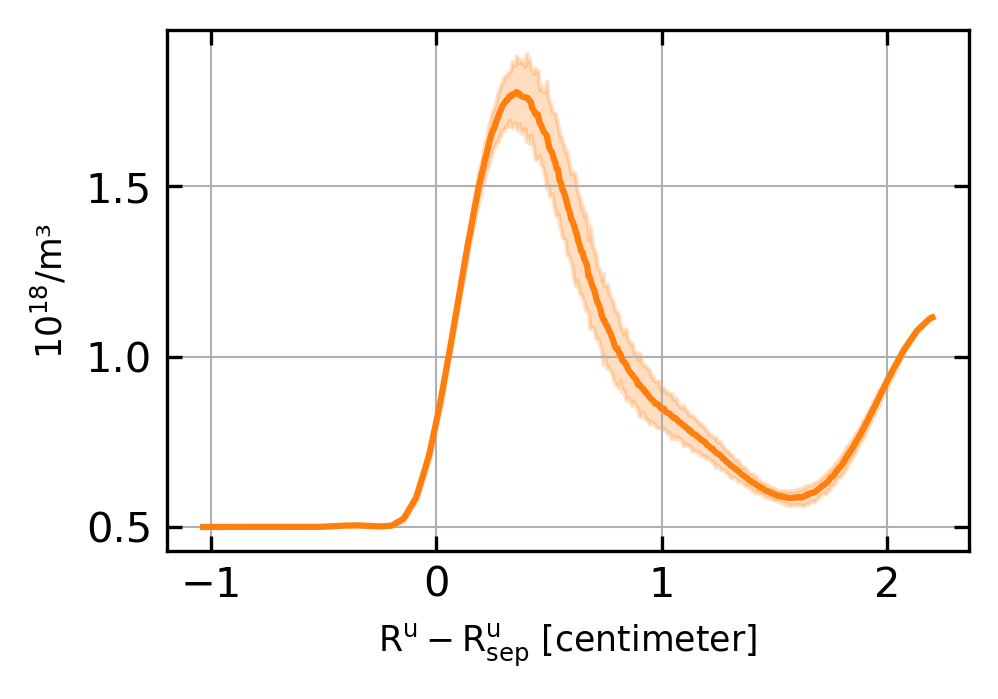

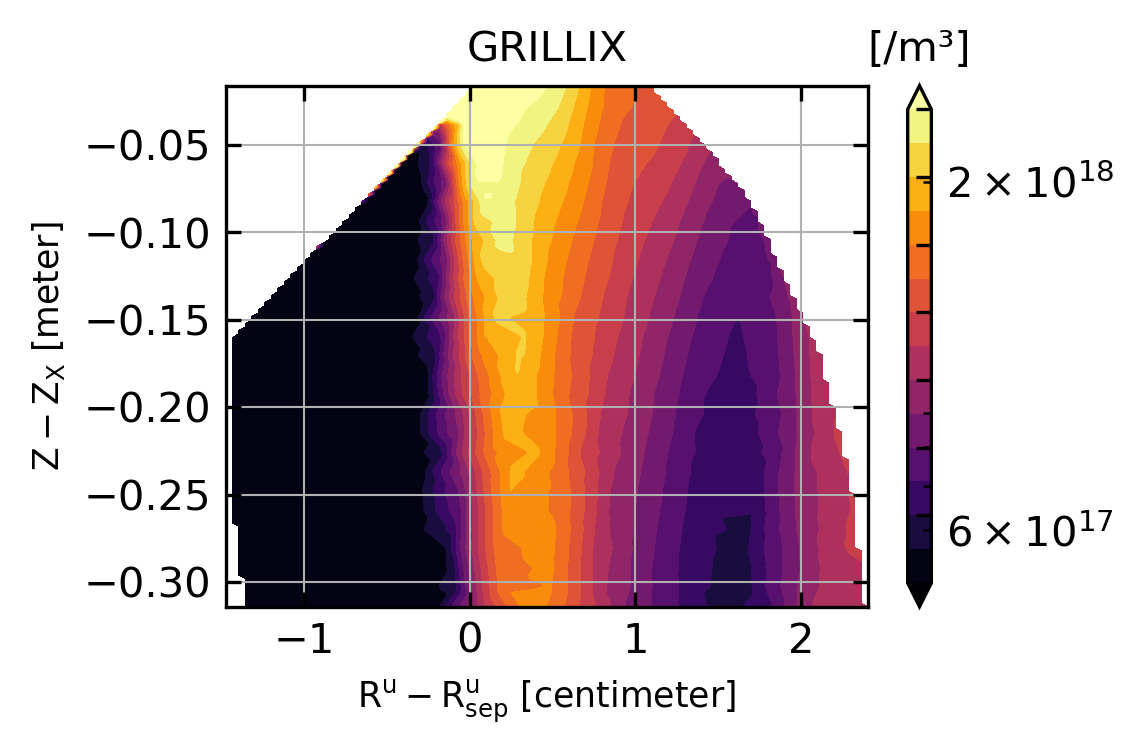

In [19]:
from tcvx21.record_c.record_m import Record

ds = Record(file_path/'GRILLIX_example.nc', color='C1', label='GRILLIX')

plt.figure()
ds.get_observable('LFS-LP', 'density').plot()

plt.figure()
ds.get_observable('RDPA', 'density').plot(log_cbar=True)